In [1]:
# -*- coding: utf-8 -*-
'''
Created on Oct 2023

@authors:   Jamie Taylor (CUNEF) 
            Manuela Bastidas (UPV/EHU)
            https://www.mathmode.science/ 
            
Updated on Jan 2025 by:
    Ángel Javier Omella
'''

# This code presents a simple implementation of Physics-Informed 
# Neural Networks (PINNs) as a collocation method. -- <50 lines of PINNS--

# In this 1D example, we utilize Keras for constructing neural networks 
# and TF in the backend. 


import tensorflow as tf


#Device control
print("Number available GPUs:", len(tf.config.list_physical_devices('GPU')))
# Hide GPU from visible devices to enforce CPU execution
tf.config.set_visible_devices([], 'GPU')
print("Number GPUs used:", tf.config.list_logical_devices('GPU'))

#It is usual to have trubles with the path of the library libdevice.10.bc for execution in GPU mode
# You have to locate it with the command
  # find / -type d -name nvvm 2>/dev/null
  #In my case with the result: /home/ajaome/miniconda3/envs/course/nvvm
  # and export the variable:
# export XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/ajaome/miniconda3/envs/course/
#Once it works. You can configure an enviromnemt variable by the command:
#conda env config vars set XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/ajaome/miniconda3/envs/course/

import numpy as np
import matplotlib.pyplot as plt

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
keras.backend.set_floatx(dtype)


# =============================================================================
# 
#          Source code - PINNs H01 1D 
#
# =============================================================================


## Define an approximate solution (u_nn): A neural network model
def make_model(neurons, n_layers, activation='tanh'):
    
    """
    Creates a neural network model to approximate the solution of 
        int (grad u ).(grad v) - int f.v = 0

    Args:
        neurons (int): The number of neurons in each hidden layer.
        activation (str, optional): Activation function for hidden layers.

    Returns:
        keras.Model: A neural network model for the approximate solution.
    """
    
	# The input
    xvals = keras.layers.Input(shape=(1,), name='x_input',dtype=dtype)

    ## ---------------
    #  The dense layers
    ## ---------------
    
    # First layer
    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xvals)
    for l in range(n_layers-2):
        # Hidden layers
    	l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)
    # Last layer
    output = keras.layers.Dense(1, activation=activation, dtype=dtype)(l1)

    u_model = keras.Model(inputs = xvals, outputs = output, name='u_model')

    # Print the information of the model u
    u_model.summary()

    return u_model

##PINNs loss function ( loss into layer )
class loss(keras.layers.Layer):
    def __init__(self,u_model,n_pts,f,**kwargs):
    
        """
        Initializes the PINNS loss layer with provided parameters.
    
        Args:
            u_model (keras.Model): The neural network model for the approximate 
                                    solution.
            n_pts (int): Number of integration points.
            f (function): Source - RHS of the PDE 
            
            kwargs: Additional keyword arguments.
        """
        super(loss, self).__init__()
    
        self.u_model = u_model
        self.n_pts = n_pts
        self.f = f
        
        
    def call(self,inputs):
        
        """
        Computes the collocation - PINNs loss.

        Args:
            inputs: The input data (dummy).

        Returns:
            keras.Tensor: The loss value.
        """
        
        # Generate random integration points
        x = tf.random.uniform([self.n_pts],dtype=dtype,maxval=np.pi)
        
        # Take gradients (tf based part)
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(x)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(x)
                u = self.u_model(x, training=True)
            dux = t2.gradient(u,x)
        duxx = t1.gradient(dux,x)
        
        ## u''-sin(2x)=0 is eq, PDE loss
        error_PDE = keras.ops.mean((duxx-self.f(x))**2)
        
        ##Dirichlet BC loss
        bc = self.u_model(np.array([np.pi]))**2 + self.u_model(np.array([0.]))**2
        return error_PDE + bc
    

## Create a loss model
def make_loss_model(u_model, n_pts, f):
    """
    Constructs a loss model for PINNs.

    Args:
        u_model (keras.Model): The neural network model for the approximate solution.
        n_pts (int): Number of integration points.

    Returns:
        keras.Model: A model with the collocation-based loss function.
    """
    xvals = keras.layers.Input(shape=(1,), name='x_input', dtype=dtype)
    
    # Compute the loss using the provided neural network and 
    # integration parameters
    output = loss(u_model, n_pts, f)(xvals)

    # Create a Keras model for the loss
    loss_model = keras.Model(inputs=xvals, outputs=output)
    
    return loss_model


def tricky_loss(y_pred, y_true):
    """
    A placeholder loss function that can be replaced as needed.

    Args:
        y_pred: Predicted values.
        y_true: True values.

    Returns:
        float: The loss value.
    """
    # This is a placeholder loss function that can be substituted with a 
    # custom loss if required.
    return y_true

# =============================================================================
# 
#          Example 1 - Inputs
#
# =============================================================================

# PDE RHS 
def f_rhs(x):
   return -4*keras.ops.sin(2 * x)

# Number of neurons per hidden layer in the neural network
nn = 10
# Number of hidden layers 
nl = 4
# Number of integration points
n_pts = 1000
# Number of training iterations
iterations = 1000

# Initialize the neural network model for the approximate solution
u_model = make_model(neurons=nn, n_layers=nl)

# Big model including the  loss
loss_model = make_loss_model(u_model, n_pts, f_rhs)

# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=10**-3)

# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

# Train the model using a single training data point ([1.], [1.]) for a 
# specified number of epochs (iterations)
history = loss_model.fit(np.array([1.]), np.array([1.]), epochs=iterations)


2025-01-19 21:11:25.072112: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 21:11:25.074247: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 21:11:25.077869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 21:11:25.088601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 21:11:25.105884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Number available GPUs: 0
Number GPUs used: []


I0000 00:00:1737331889.315967    4434 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-19 21:11:29.317407: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "u_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x_input (InputLayer)            │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251 (1.96 KB)

 Trainable params: 251 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7.8657
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.8966

2025-01-19 21:11:30.631544: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631657: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631718: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631745: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631796: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631826: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631888: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.631917: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.632024: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.632052: W tensorflow/core/util/util.cc:161] Not handling type DT_DOUBLE
2025-01-19 21:11:30.632100: W tensorflow/core/util/util.cc:161] Not handling typ

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.8966
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 7.7788
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 7.7318
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 7.8856
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.6441
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.6649
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.8175
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.5900
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.9307
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.5565
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.4209
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.0700
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 7.3562
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 7.4873
Epoch 16/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.0956
Epoch 17/1000
1/

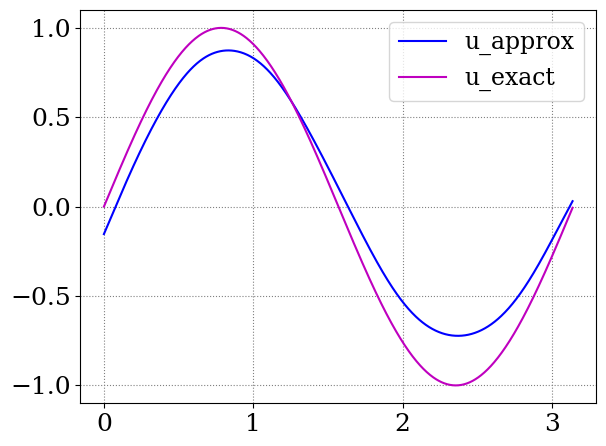

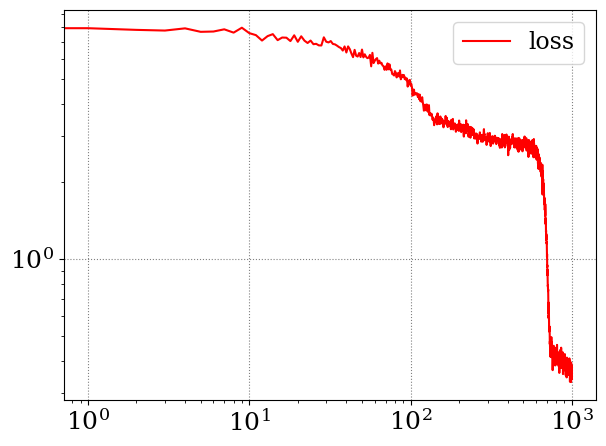

In [2]:
## ----------------------------------------------------------------------------
#   Plot the results
## ----------------------------------------------------------------------------

from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm' 
rcParams['axes.labelsize'] = 19

# Exact solution
def exact_u(x):
    return keras.ops.sin(2 * x)

# Generate a list of x values for visualization
xlist = np.array([np.pi/1000 * i for i in range(1000)])

## ---------
# SOLUTION
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(xlist, u_model(xlist), color='b')
plt.plot(xlist, exact_u(xlist), color='m')

plt.legend(['u_approx', 'u_exact'])

ax.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()


## ---------
# Loss evolution
## ---------

fig, ax = plt.subplots()
# Plot the approximate solution obtained from the trained model
plt.plot(history.history['loss'], color='r')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(['loss'])

ax.grid(which = 'major', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()
plt.show()